# Day2　NumPyを扱うコツ
テトリスは、7種類のブロック (「ミノ」と呼びます) + ブロックの置かれていない状態の計8種類のマスを、高さ22段×横10列の盤面に並べている、と言えます。
そしてソースコードでは、置かれていない状態を「0」、I字型のミノを「1」、L字型のミノを「2」・・・とした、「0」から「7」までの数字が220個並んだものによって表現されています。<br><br>

この数字の並びを「配列」と呼びます。配列はその値を読み書きしたり、値を使って計算したりできます。ここでは、数学パズルのような問題を解いていくことを通じて、テトリスのソースコードに登場する配列の操作を学びます。
- リスト・配列・NumPy配列の違い
- サイズ (reshape)
- 結合 (vstack)
- 削除 (delete)
- 検索 (where)
- 演算 (sum・mean・max・min)
- 乱数 (random)

## 1. おまじない
前回のタートルグラフィックスと同様に、NumPyの機能を使えるようにするには`import`をします。このおまじないの後ろに`as`をつけて好きな文字列 (この場合は`np`)を書くと、`turtle.`や`numpy.`と書く必要があるところを、`np.`のように別の名前を付けてあげることができます。NumPyの場合は、その大文字を取って略されることが慣例です。

In [1]:
import numpy as np

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt

colors = [[0,255,0],
          [255,0,0],
          [0,0,0]]

def drawArray(a,size = 20):
    if a.ndim == 1:
        a = a.reshape((1,a.shape[0]))
    block_array = []
    fig, ax = plt.subplots()
    size = max(size/a.shape[0],a.shape[0]/size)
    #size = max(size/a.shape[1],a.shape[1]/size)
    fig.set_figwidth(a.shape[0] * size)
    fig.set_figheight(a.shape[1] * size)
    for i in range(a.shape[0]):
        row = []
        for j in range(a.shape[1]):
            c = colors[int(a[i][j])]
            row.append(c)
        block_array.append(row)
    block_array = np.array(block_array)
    im = plt.imshow(block_array)

    #グリッド線を引く
    ax.set_xticks(np.arange(-0.5, a.shape[1], 1.0), minor=True)
    ax.set_yticks(np.arange(-0.5, a.shape[0], 1.0), minor=True)
    ax.set_xticks(np.arange(-0.5, a.shape[1], 10))
    ax.set_yticks(np.arange(-0.5, a.shape[0], 3))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax.imshow(block_array)


- - -

## 2. 問題「隣り合わないのがマナー？」
電車などで、空いている座席に座ることを考えます。一種のマナーなのか、自然と隣が空いている座席を選ぶことが多いようです。今回の問題でも、1列の座席で、他人と隣り合わずに座れる場合は他人の隣に座らないことにします。隣り合わないと座れない場合は、空いているところに座っていきます。<br><br>

6人が座れるロングシートが向かい合った電車を考えます (横浜船や京阪の各駅停車を想像してください)。計12席がある車両に12人が乗ってくる場合、12人の座る順番が何通りあるかを、プログラミングでパソコンに計算させてみましょう（座席はすべて区別でき、それぞれの座席には1人ずつ座るものとします）。

- - - 

## 3. 穴埋めをしながらプログラムを完成させよう
穴埋めをしていただきたい不完全な箇所には、前回と同様に<br>
`#------------ここから--------------`<br>
<br>
`#------------ここまで--------------`<br>
を記載しています。<br><br>

### 座席をプログラミングで表現するには？
テトリスのソースコードがミノの置かれていない状態を「0」、I字型のミノが存在する状態を「1」と数字を用いて表していたように、電車の座席も数字の並びとして表すことからスタートします。<br><br>

当たり前ではありますが、問題文より電車の座席には

- 空いている
- 誰か座っている

という2つの状態があります。ここでは、空いている状態を「0」、誰か座っている状態を「1」としましょう。もちろんこの数字は好きな値でも構わないのですが、NumPyに用意されている機能を考慮すると、0や1であると扱いやすいです。ここでは変数に予め値を代入しておきます。

In [2]:
FREE = 0
USED = 1

さて座席はすべて区別できると問題文に指定があるので、新幹線や特急列車のように各座席に番号を割り当てて状態を記録することにしましょう。ここでPythonでプログラミングをする場合には、ひと工夫を施してあげると非常にコードがスッキリします。<br><br>

まず、<b>Pythonの配列では番号は0から</b>始まる仕様があります。座席番号も「1番座席、2番座席、・・・、12番座席」と割り当てるのが直感的ではありますが、Pythonの仕様に合わせて「0番座席、1番座席、・・・、11番座席」と改番してあげる必要があります。Pythonでは「1番座席」は最も端の座席ではなく、その1つ隣の座席を表すのです。<br><br>

そして、問題文には「ロングシートが向かい合った」と記載がありますが、別に<b>座席が一列に並んでいても同じこと</b>であると言えると思います。ただし12人掛けのロングシートではなく、2つのロングシートの両端は1人だけしか隣に座りません。埋まってはいるけれども隣に座っても構わない、壁のようなものが両端の人の隣にあるとイメージしてください (実際の電車でも、ロングシートの両端には仕切り板が付いていますよね。よくドア横の人が寄りかかっているやつ)。つまり、6人掛けのロングシートを2つ横並びしたときに壁もカウントすれば、「0番<b>壁</b>、1番座席、2番座席、・・・、6番座席、7番<b>壁</b>、8番座席、・・・13番座席、14番<b>壁</b>」という座席番号を割り振っても良い、と言えます。なぜならば座席は12個あるし、ロングシートの人が片一方側は壁だから気にしなくて良いことを再現できているからです。<br><br>

壁という、埋まってはいるけれども隣に座っても構わない状態を増やしたので、上と同様に変数を増やしておきます。

In [3]:
WALL = 2

いよいよ、座れる座席12個と壁3ヶ所の、計15個の数字の並びを作りましょう。電車の座席ははじめ誰も座っていないので、0がたくさん並んだ配列を作りましょう。ここでは、いったん15個の`FREE`が並ぶ配列を作ってから壁の位置だけ`WALL`に置き換えてあげる、という2ステップの操作を行ってみることにします。<br><br>

NumPyには、並べたい0の個数を指定できる`zeros()`という機能 (関数)が備わっています。タートルグラフィックスで言うところの、`forward()`や`right()`と同じ使い方をします。`seat`という変数に`zeros()`という関数を使って、0が15個並んだ配列を作成してください。

In [4]:
#------------ここから--------------
seat = np.zeros(15)
#------------ここまで--------------

試しに、この配列`seat`をprint文によって表示してみましょう。たしかに、0が15個並んでいることが分かると思います。こうして配列として並ばせた数字のことを、配列の「要素」と呼びます。今回のように要素数が15だけであれば目視で数えることができますが、もっと大きなサイズの配列になるとprint文で配列の全体を確認することが困難になります。<br><br>

そこで、NumPyの配列は`size`によって調べることのできる要素数という「属性」を持っています。変数`seat`の`size`をprintするコードを完成させてください。以下を実行し、<br>
`[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]`<br>
`15`<br>
と表示されれば成功です。

In [118]:
print(seat)
#------------ここから--------------
print(seat.size)
#------------ここまで--------------

[2. 1. 1. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 2.]
15


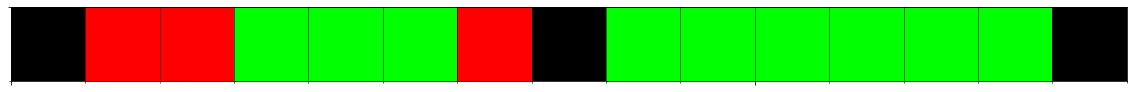

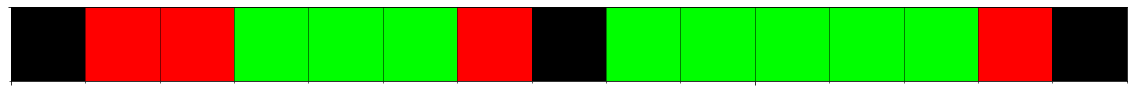

In [119]:
# ★Drawを追加
drawArray(seat)

seat[1] = 1
seat[2] = 1
seat[6] = 1
seat[13] = 1
drawArray(seat)

この配列は、「0番<b>壁</b>、1番座席、2番座席、・・・、6番座席、7番<b>壁</b>、8番座席、・・・13番座席、14番<b>壁</b>」という座席番号を割り当てたものでした。最後に、壁という扱いをした

- 0番目
- 7番目
- 14番目

の要素を、`WALL`に置き換えましょう。配列`seat`全体ではなく、ある要素の値に着目したいときには、`seat[要素番号]`という書き方をします。着目したい要素が複数ある場合、`[]`の中に`,`区切りで数字を列挙したもの (Pythonの文法用語で「list」型と呼ばれる書き方です)を書きます。

In [6]:
#------------ここから--------------
seat[[0, 7, 14]] = WALL
#------------ここまで--------------

念のため、もう一度配列をprintしてみましょう。たしかに以下のように、0・7・14番目 (直感的に数えれば左から1・8・15番目)の値が2に変わったことが分かると思います。<br>
`[2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2.]`

In [7]:
print(seat)

[2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2.]


### どうやって座れる場所を選ぶか？
(文面考え中。今日は力尽きた。答えは「14100480通り」)

In [8]:
answer = 0

In [9]:
def search(person):
    # 計算が終了する条件は、0がすべて1に変わって全要素の和が18になること
    #------------ここから--------------
    if np.sum(seat) == 18:
        answer = answer + 1
    #------------ここまで--------------
    else:
        for No in range(1, person - 1):
            #------------ここから--------------
            if all([seat[No - 1] != USED, seat[No] == FREE, seat[No + 1] != USED]):
                seat[No] = USED
                search(person - 1)
                seat[No] = FREE
            #------------ここまで--------------

In [10]:
search(15)
print(answer)

0
